# Project Luther: Predicting the Market Value of NBA Players

Name: Paul Lim

Date: 04/28/2017

In [29]:
# Relevant libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import pipeline, feature_selection, decomposition
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import RFECV
import logging


import warnings
warnings.filterwarnings('ignore')

sns.set_style("white")
sns.set_style('ticks')
sns.set_style({'xtick.direction': u'in', 'ytick.direction': u'in'})
sns.set_style({'legend.frameon': True})

%matplotlib inline

## List of Classes/Functions

In [2]:
# Running list of classes/functions

class IdentityTransform(BaseEstimator, TransformerMixin):
    '''
    Maintains the original matrix of features.
    '''
    def fit(self, x, y=None):
        return self

    def transform(self, X):
        return X

def bball_get_col(table, col_tag='th'):
    '''
    The columns of the table should be in the first 'tr' tag within the table tag.  
    The columns will be found as either 'th' or 'td' tags within the 'tr' tag.  
    The 'th' tag is set as default.
    '''
    col_loc = table.find('tr')
    cols = col_loc.find_all(col_tag)

    cols_list = []
    for i in range(len(cols)):
        temp_col = cols[i].get_text()
        cols_list.append(temp_col)
        
    return cols_list

def bball_get_data(table, data_tag='td'):
    '''
    The data within a table should be the second through last 'tr' tag within the table tag.
    The data should be found as 'td' tags, so the default data tag is set to 'td'.
    '''
    all_rows = table.find_all('tr')[1:]

    all_data = []

    for i in range(len(all_rows)):
        row = all_rows[i].find_all('th')
        add_row = all_rows[i].find_all('td')
        row.extend(add_row)
        data = []
        for j in range(len(row)):
            datapoint = row[j].get_text()
            data.append(datapoint)
        all_data.append(data)
        
    return all_data

def bball_scrape_data(url_template, start_year, end_year, delay=5):
    '''
    The url_template should be a formatted string where the start_year and end_year can be cycled through.
    The start_year and end_year should be integers.
    The col_list should be a list.
    The default data_tag is 'td'.
    The delay, which delays each run through of the for loop, is set to 5 seconds as default.  
    The delay prevents the scraper from being blocked due to frequent scraping requests.
    '''
    df = pd.DataFrame()
    
    if start_year > end_year:
        return print('Enter in valid end year.')
    else: 
        for year in range(start_year, end_year+1):
            try:
                url = url_template.format(year=year)
                link = requests.get(url)
            except:
                print(url)
                print('Check to make sure the URL is correct!')
            
            print(url)
            page = link.text

            soup = BeautifulSoup(page, 'lxml')
            table = soup.find('table')

            col_list = bball_get_col(table)
            all_data = bball_get_data(table)
            
            if not col_list or not all_data:
                print(url)
                print('Webpage may be empty.')
                pass
            elif len(col_list) != len(all_data[0]):
                print('Column List: \n', col_list)
                print('Data Row: \n', all_data)
                return print('Make sure the length of columns and data are consistent!')
            else:
                temp_df = pd.DataFrame(all_data, columns=col_list)
                temp_df = temp_df.assign(Yr = year)
                df = df.append(temp_df)
            time.sleep(delay)

    return df




def sal_get_col(table_sal):
    '''
    Column headers were found in the 'td' tags within the first 'tr' tag.
    '''
    col_loc_sal = table_sal.find('tr')
    cols_sal = col_loc_sal.find_all('td')

    cols_list_sal = []
    for i in range(len(cols_sal)):
        temp_col_sal = cols_sal[i].get_text()
        cols_list_sal.append(temp_col_sal)
    return cols_list_sal

def sal_get_data(table_sal):
    '''
    All of the data were found in the 'td' tags within the 'tr' tags that had the class 'evenrow' or 'oddrow'.
    '''
    all_rows_sal = table_sal.find_all('tr', class_ = ['evenrow', 'oddrow'])

    all_data_sal = []

    for i in range(len(all_rows_sal)):
        row_sal = all_rows_sal[i].find_all('td')
        data_sal = []
        for j in range(len(row_sal)):
            datapoint_sal = row_sal[j].get_text()
            data_sal.append(datapoint_sal)
        all_data_sal.append(data_sal)
        
    return all_data_sal

def sal_scrape_data(url_template, start_year, end_year, start_page, end_page, delay=5):
    '''
    Function to scrape the salary data from ESPN.com. The url_template should be a formattable
    string that takes in the start_year through the end_year. Since each year had multiple pages
    the url_template should also be able to take in the start_page through the end_page.
    '''
    df = pd.DataFrame()
    
    if start_year > end_year:
        return print('Enter in valid end year.')
    elif start_page > end_page:
        return pring('Enter in a valid end page.')
    else: 
        for year in range(start_year, end_year+1):
            for page in range(start_page, end_page+1):
                try:
                    url = url_template.format(year=year, page=page)
                    link = requests.get(url)
                except:
                    print(url)
                    print('Check to make sure the URL is correct!')
                
                page = link.text

                soup = BeautifulSoup(page, 'lxml')
                table = soup.find('table')

                col_list = sal_get_col(table)
                all_data = sal_get_data(table)
                
                if not col_list or not all_data:
                    print(url)
                    print('Webpage may be empty.')
                    pass
                elif len(col_list) != len(all_data[0]):
                    print('Column List: \n', col_list)
                    print('Data Row: \n', all_data)
                    return print('Make sure the length of columns and data are consistent!')
                else:
                    temp_df = pd.DataFrame(all_data, columns=col_list)
                    temp_df = temp_df.assign(Yr = year)
                    df = df.append(temp_df)
                time.sleep(delay)
                
    return df


def square_features(df, col_list):
    '''
    Function that creates the squared term of the features in the col_list.
    The dataframe that is returned contains the original features with the additional squared features.
    '''
    for col in col_list:
        new_col_name = col + '_sq'
        df[new_col_name] = df[col].apply(lambda x: x**2)
    return df

def cube_features(df, col_list):
    '''
    Function that creates the cubed term of the features in the col_list.
    The dataframe that is returned contains the original features with the additional cubed features.
    '''
    for col in col_list:
        new_col_name = col + '_cube'
        df[new_col_name] = df[col].apply(lambda x: x**3)
    return df

def rank_features(df, groupby_list, rank_list):
    '''
    Function that ranks the players in the particular groupby object specified by the groupby_list.
    The dataframe that is returned contains the original features with the additional ranked features.
    '''
    df_rank = df.groupby(groupby_list).rank(ascending=True)
    new_col_list = []
    for col in rank_list:
        new_col_name = col + '_rk'
        df_rank[new_col_name] = df_rank[col]
        new_col_list.append(new_col_name)
    return df_rank[new_col_list]


def rand_features(df, col_names):
    '''
    Function that creates noisy features that contain integers between 0 and 10000.
    The dataframe that is returned contains the original dataframe with the additional noisy features.
    '''
    for col in col_names:
        df[col] = np.random.randint(0,10000,len(df))
    return df


def run_pipelines(model_dict, X, y, feature_list, param_dict):
    '''
    Runs through a pipeline for each type of model.
    feature_list = list of tuples.
    param_dict = a nested dictionary that contains the hyper parameters that need to be tuned.
    '''
    logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
    grid_dict = {}
    
    for name, model in sorted(model_dict.items()):
        if feature_list:
            combined_features = pipeline.FeatureUnion(feature_list)

            steps = [
                ('features', combined_features),
                ('feature_selection', feature_selection.SelectFromModel(linear_model.Lasso(alpha=2))),
                ('model', model)
                ]
        else:
            steps = [
                ('feature_selection', feature_selection.SelectFromModel(linear_model.Lasso(alpha=2))),
                ('model', model)
                ]
        
        regression_pipeline = pipeline.Pipeline(steps)
        if name in param_dict:
            parameters = param_dict[name]
        else:
            return print('Incorrect parameters in the parameter dictionary.')
            
        grid_dict[name] = GridSearchCV(regression_pipeline, parameters, n_jobs=3, verbose=1)
        train_fit = grid_dict[name].fit(X_train, y_train)
        print('Model: ', name)
        print('Best Score: %0.3f' % train_fit.best_score_)
        print('Optimal Parameters: ', train_fit.best_params_)
         
    return grid_dict


def fit_models(model_dict, df, col_list, target):
    '''
    Similar to the run_pipelines function. This function runs a 5-fold cross-validation on the models
    defined in the model_dict. The models are fit to the training and test sets from the df and the target
    that is specified in the inputs.
    '''
    X = df.loc[:,col_list]
    y = df.loc[:,target]
    
    X_arr = X.as_matrix()
    y_arr = y.as_matrix()
    
    list_scores = []
    list_dict = []
    total_model_dict = {}
    kf = KFold(n=len(X_arr), n_folds=5)
    for name, model in sorted(model_dict.items()):

        temp_score_list = []
        temp_train_score_list = []
        for split_indices in kf:
            train_ind = list(split_indices[0])
            test_ind = list(split_indices[1])
            
            X_train = X_arr[train_ind]
            X_test = X_arr[test_ind]
            y_train = y_arr[train_ind]
            y_test = y_arr[test_ind]
            
            model.fit(X_train, y_train)
            if hasattr(model, 'score'):
                temp_score = model.score(X_test, y_test)
                temp_score_list.append(temp_score)
            
                temp_train_score = model.score(X_train, y_train)
                temp_train_score_list.append(temp_train_score)
            elif hasattr(model, 'score_'):
                temp_score = model.score_(X_test, y_test)
                temp_score_list.append(temp_score)
            
                temp_train_score = model.coef_(X_train, y_train)
                temp_train_score_list.append(temp_train_score)
            if name not in total_model_dict:
                total_model_dict[name] = []
            else:
                total_model_dict[name].append(model)

        print('Model: ' + name)
        print('Test Score: ' + str(np.mean(temp_score_list)) + ' with STD: ' + str(np.std(temp_score_list)))
        print('Train Score: ' + str(np.mean(temp_train_score_list)) + ' with STD: ' + str(np.std(temp_train_score_list)))
    return total_model_dict


def plot_overfit(X,y,model_obj,param_ranges,param_static=None): 
    '''
    Function that outputs the plot of the hyper parameter versus the score.
    '''
    for parameter,parameter_range in param_ranges.items():
        avg_train_score, avg_test_score = [],[]
        std_train_score, std_test_score = [],[]
        
        for param_val in parameter_range:
            param = {parameter:param_val}
            if param_static:
                param.update(param_static)
                
            model = model_obj(**param)
            
            train_scores,test_scores = [],[]
            for i in range(5):
                X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = .3)
                model.fit(X_train,y_train)
                
                train_scores.append(model.score(X_train,y_train))
                test_scores.append(model.score(X_test,y_test))
            
            avg_train_score.append(np.mean(train_scores))
            avg_test_score.append(np.mean(test_scores))
            
            std_train_score.append(np.std(train_scores))
            std_test_score.append(np.std(test_scores))
            
        fig,ax = plt.subplots()
        
        if parameter == 'alpha':
            ax.errorbar(np.log(parameter_range),avg_train_score,yerr=std_train_score,label='training score')
            ax.errorbar(np.log(parameter_range),avg_test_score,yerr=std_test_score,label='testing score')
            ax.set_xlabel('ln(' + parameter + ')', fontsize='14')
        else:
            ax.errorbar(parameter_range,avg_train_score,yerr=std_train_score,label='training score')
            ax.errorbar(parameter_range,avg_test_score,yerr=std_test_score,label='testing score')  
            ax.set_xlabel(parameter)
            
        ax.set_ylabel('score', fontsize='14')
        ax.set_title(parameter + ' tuning', fontsize='16')
        ax.legend(loc=0, frameon=True)
        sns.set_style("white")
        sns.set_style('ticks')
        sns.set_style({'xtick.direction': u'in', 'ytick.direction': u'in'})
        ttl = ax.title
        ttl.set_position([.5, 1.05])


## Basketball-reference Web Scrape

In [ ]:
# Test the web scrape
url_bball = 'http://www.basketball-reference.com/leagues/NBA_2016_totals.html'
link_bball = requests.get(url_bball)
page_bball = link_bball.text

soup_bball = BeautifulSoup(page_bball, 'lxml')
table_bball = soup_bball.find('table')

### Get column headers

In [ ]:
# Pull column names from the table
# th should be in the first tr tag
col_loc_bball = table_bball.find('tr')
cols_bball = col_loc_bball.find_all('th')

cols_list_bball = []
for i in range(len(cols_bball)):
    temp_col_bball = cols_bball[i].get_text()
    cols_list_bball.append(temp_col_bball)

### Get data

In [ ]:
# Pull data from the table
# td tags in the second through last tr tag should contain all of the data
all_rows_bball = table_bball.find_all('tr')[1:]

all_data_bball = []

for i in range(len(all_rows_bball)):
    row_bball = all_rows_bball[i].find_all('td')
    data_bball = []
    for j in range(len(row_bball)):
        datapoint_bball = row_bball[j].get_text()
        data_bball.append(datapoint_bball)
    all_data_bball.append(data_bball)

# Remove the first column name since it is just another index of the player list
df_2016 = pd.DataFrame(all_data_bball, columns=cols_list_bball[1:])

### Combine the above three steps into one function

In [ ]:
# Combine the above steps into one function that can run through multiple urls

# Get the advanced data from 2000 to 2016

bball_ref_url = 'http://www.basketball-reference.com/leagues/NBA_{year}_advanced.html'
start_year = 2000
end_year = 2017

df_bball = bball_scrape_data(bball_ref_url, start_year, end_year)
df_bball.head()
        

### Save dataframe to csv file

In [ ]:
# Save the dataframe to a csv file
df_bball.to_csv('data/bball_ref_player_database.csv')

### Repeat the process for the non-advanced stats for players

In [ ]:
bball_tot_url = 'http://www.basketball-reference.com/leagues/NBA_{year}_totals.html'
bball_per_url = 'http://www.basketball-reference.com/leagues/NBA_{year}_per_game.html'

start_year = 2000
end_year = 2017

df_bball_tot = bball_scrape_data(bball_tot_url, start_year, end_year)
print(df_bball_tot.head())

df_bball_per = bball_scrape_data(bball_per_url, start_year, end_year)
print(df_bball_per.head())

### Save dataframes to a csv file

In [ ]:
# Save the dataframe to a csv file
df_bball_tot.to_csv('data/bball_ref_player_database_tot.csv')
df_bball_per.to_csv('data/bball_ref_player_database_per.csv')

## NBA Player Salaries Web Scrape

In [ ]:
# Get the salary data from 2000 to 2017

# Test the web scrape
url_sal = 'http://www.espn.com/nba/salaries/_/year/2000/page/1/seasontype/3'
link_sal = requests.get(url_sal)
page_sal = link_sal.text

soup_sal = BeautifulSoup(page_sal, 'lxml')
table_sal = soup_sal.find('table')

In [ ]:
# Pull column names from the table
# First tr tag contains td tags that are the column names
col_loc_sal = table_sal.find('tr')
cols_sal = col_loc_sal.find_all('td')

cols_list_sal = []
for i in range(len(cols_sal)):
    temp_col_sal = cols_sal[i].get_text()
    cols_list_sal.append(temp_col_sal)

In [ ]:
# Pull data from the table
# td tags in every tr tag with the class 'evenrow' and 'oddrow' have the salary data
all_rows_sal = table_sal.find_all('tr', class_ = ['evenrow', 'oddrow'])

all_data_sal = []

for i in range(len(all_rows_sal)):
    row_sal = all_rows_sal[i].find_all('td')
    data_sal = []
    for j in range(len(row_sal)):
        datapoint_sal = row_sal[j].get_text()
        data_sal.append(datapoint_sal)
    all_data_sal.append(data_sal)

In [ ]:
# Create the dataframe
df_sal_2000 = pd.DataFrame(all_data_sal, columns=cols_list_sal)

In [ ]:
salary_url = 'http://www.espn.com/nba/salaries/_/year/{year}/page/{page}/seasontype/3'
start_year2 = 2000
end_year2 = 2017
start_page = 1
end_page = 4

df_sal = sal_scrape_data(salary_url, start_year2, end_year2, start_page, end_page)
df_sal.head()

In [ ]:
# Save the dataframe to a csv file
df_sal.to_csv('data/salary_database.csv')

## Cleaning Data

### Cleaning the player stats dataframes

In [3]:
# Load the player stats databases.
df_csv2 = pd.read_csv('data/bball_ref_player_database.csv')
df_csv3 = pd.read_csv('data/bball_ref_player_database_tot.csv')
# df_csv4 = pd.read_csv('bball_ref_player_database_per.csv')

In [4]:
# Remove the Unnamed and Rk columns
df_adv = df_csv2.iloc[:,2:]
df_tot = df_csv3.iloc[:,2:]
# df_per = df_csv4.iloc[:,2:]

# Remove the rows there the Tm column value is 'Tm'. This indicates that the column headers were repeated in the df.
df_adv = df_adv[df_adv['Tm'] != 'Tm']
df_tot = df_tot[df_tot['Tm'] != 'Tm']
# df_per = df_per[df_per['Tm'] != 'Tm']

# The Player column has asteriks and other markers to denote things about the player. 
# These markers will be removed since the Player column is needed in order to join the two databases in the future.
df_adv['Player'] = df_adv['Player'].map(lambda x: re.sub(r"\*", '', x))
df_tot['Player'] = df_tot['Player'].map(lambda x: re.sub(r"\*", '', x))
# df_per['Player'] = df_per['Player'].map(lambda x: re.sub(r"\*", '', x))

In [5]:
# Some players played on multiple teams in the same year due to trades.
# These players will have their stats averaged to one value.
df_adv2 = df_adv.sort(columns=['Player','Yr','Pos','Tm'])
df_adv2 = df_adv2.apply(pd.to_numeric, errors='ignore')
df_adv2 = df_adv2.groupby(['Player','Yr','Pos','Tm']).mean().reset_index()

df_tot2 = df_tot.sort(columns=['Player','Yr','Pos','Tm'])
df_tot2 = df_tot2.apply(pd.to_numeric, errors='ignore')
df_tot2 = df_tot2.groupby(['Player','Yr','Pos','Tm']).mean().reset_index()

# df_per2 = df_per.sort(columns=['Player','Yr'])
# df_per2 = df_per2.apply(pd.to_numeric, errors='ignore')
# df_per2 = df_per2.groupby(['Player','Yr']).mean().reset_index()

### Cleaning the salary data

In [6]:
# Load the salary csv file
df_csv = pd.read_csv('data/salary_database.csv')

In [7]:
# Remove the Unnamed: 0 column and the RK column.
df_salary = df_csv.iloc[:,2:]

# Edit the Name column so that only the names are left.
df_salary['NAME'] = df_salary['NAME'].map(lambda x: re.sub(r",\s.+", '', x))

In [8]:
# Edit the Salary column to an integer value.
df_salary['SALARY'] = df_salary['SALARY'].map(lambda x: re.sub(r"\$", '', x))
df_salary['SALARY'] = df_salary['SALARY'].map(lambda x: re.sub(r",", '', x))
df_salary['SALARY'] = df_salary['SALARY'].map(lambda x: int(x))

In [9]:
# Adjust the Salary column to account for inflation.
# Average rate of inflation between 2000 and 2016 was 2.15%
df_salary['yr_diff'] = df_salary['Yr'].map(lambda x: 2017 - x)
df_salary['salary_adj'] = df_salary.apply(lambda x: x['SALARY']*(1 + 0.0215)**x['yr_diff'], axis=1).map(int)

In [10]:
# Ultimately the salary dataframe will only need the Name, Year, Salary, and Adjusted Salary columns. 
# The Name and Yr columns will be used as the key when joining the two databases.
df_salary_final = df_salary.loc[:,['NAME','Yr', 'SALARY', 'salary_adj']]
df_salary_final.head()

,NAME,Yr,SALARY,salary_adj
0,Shaquille O'Neal,2000,17142000,24610123
1,Kevin Garnett,2000,16806000,24127741
2,Alonzo Mourning,2000,15004000,21540677
3,Juwan Howard,2000,15000000,21534935
4,Scottie Pippen,2000,14795000,21240624


## Merging Dataframes

Join dataframes on a key formed by the year and name of the player.
Inner join will be used since the players that don't have salary information will be excluded.

In [11]:
# Since df_tot2 and df_adv2 have duplicate columns these columns will be excluded when merged.
col_to_use1 = df_tot2.columns - df_adv2.columns
df_combined1 = df_adv2.merge(df_tot2[col_to_use1], how='outer', left_index=True, right_index=True)

# The salary dataframe and the combined dataframe from above should be joined on the player name and year.
df_combined2 = df_salary_final.merge(df_combined1, how='inner', left_on=['NAME', 'Yr'], right_on=['Player', 'Yr'])
df_combined2 = df_combined2.drop('Player', axis=1)

# 3P% is null when the 3P and 3PA values are 0.0 since the 3P% is equal to 3P/3PA.
# The same applies to FT% and 2P%.
# Replace the null with 0.
df_combined2['3P%'] = df_combined2.loc[:,'3P%'].fillna(0)
df_combined2['2P%'] = df_combined2.loc[:, '2P%'].fillna(0)
df_combined2['FT%'] = df_combined2.loc[:, 'FT%'].fillna(0)
df_combined2['3PAr'] = df_combined2.loc[:, '3PAr'].fillna(0)
df_combined2['FTr'] = df_combined2.loc[:, 'FTr'].fillna(0)
df_combined2['FG%'] = df_combined2.loc[:, 'FG%'].fillna(0)
df_combined2['eFG%'] = df_combined2.loc[:, 'eFG%'].fillna(0)

# Create dummy variables for position.
pos_dict = {'C': 'C', 'PF': 'PF','SF': 'SF','PG':'PG','SG':'SG','C-PF': 'C','SF-SG':'SF','PG-SG':'PG',
           'PG-SF':'PG','SG-SF':'SG','PF-C':'PF','PF-SF':'PF','SG-PG':'SG','SG-PF':'SG','SF-PF':'SF'}
df_combined2['Pos'] = df_combined2['Pos'].map(pos_dict)
df_combined2 = pd.get_dummies(df_combined2, columns=['Pos'])

# There are columns with all null values. These columns will be dropped.
df_final = df_combined2.dropna(axis=1, how='all')
# df_final = df_final.dropna(axis=0, how='all')




# print('Length of combined df1: ', len(df_combined2))
# print('Length of salary df: ', len(df_salary_final))
# print(len(df_combined2.columns))
# print(df_combined2.columns)
# print(df_final.info())
# df_combined2.head()
# df_null = df_combined2[df_combined2['3P%'].isnull()]
# df_null['3P%'] = df_null.loc[:,'3P%'].fillna(0)
# df_null.iloc[0,25:40]
# df_final.min()

In [ ]:
# Save the dataframe to a csv file for easy reloading.
df_final.to_csv('data/merged_df.csv')

# Graph a few features versus the adjusted salary.

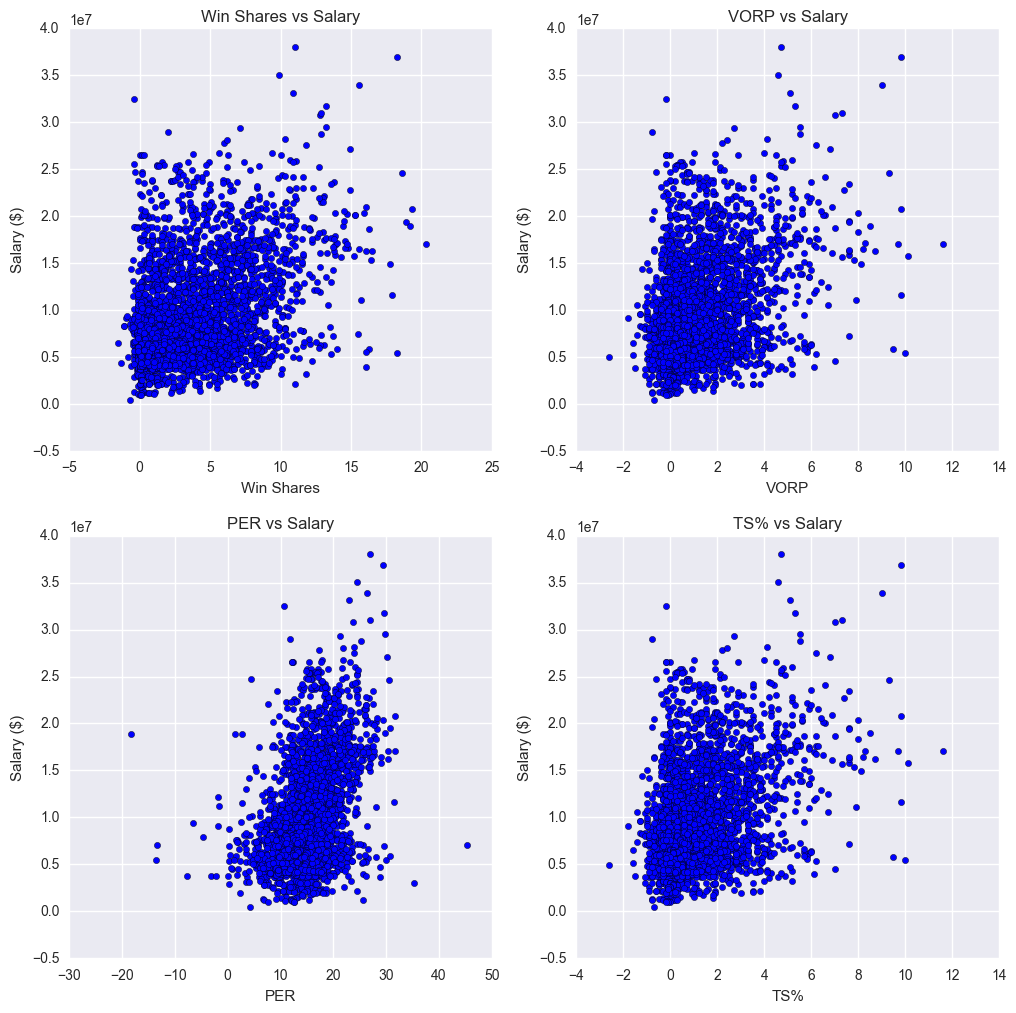

In [12]:
df_final = pd.read_csv('data/merged_df.csv')

fig, ax = plt.subplots(2,2, figsize=(12,12))

# Win Shares vs Salary
WS_list = df_final['WS'].tolist()
salary_list = df_final['salary_adj'].tolist()

ax[0,0].scatter(WS_list, salary_list)
ax[0,0].set_title('Win Shares vs Salary')
ax[0,0].set_xlabel('Win Shares')
ax[0,0].set_ylabel('Salary ($)')

# VORP vs Salary
VORP_list = df_final['VORP'].tolist()
salary_list = df_final['salary_adj'].tolist()

ax[0,1].scatter(VORP_list, salary_list)
ax[0,1].set_title('VORP vs Salary')
ax[0,1].set_xlabel('VORP')
ax[0,1].set_ylabel('Salary ($)')

# PER vs Salary
PER_list = df_final['PER'].tolist()
salary_list = df_final['salary_adj'].tolist()

ax[1,0].scatter(PER_list, salary_list)
ax[1,0].set_title('PER vs Salary')
ax[1,0].set_xlabel('PER')
ax[1,0].set_ylabel('Salary ($)')

# TS% vs Salary
TS_list = df_final['TS%'].tolist()
salary_list = df_final['salary_adj'].tolist()

ax[1,1].scatter(VORP_list, salary_list)
ax[1,1].set_title('TS% vs Salary')
ax[1,1].set_xlabel('TS%')
ax[1,1].set_ylabel('Salary ($)')

# Cross-Validation

### Visualization

In [13]:
complete_X_cols = ['Age', 'G', 'MP',
       'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM',
       'BPM', 'VORP', '2P', '2P%', '2PA', '3P', '3P%', '3PA', 'AST', 'BLK',
       'DRB', 'FG', 'FG%', 'FGA', 'FT', 'FT%', 'FTA', 'GS', 'ORB', 'PF', 'PTS',
       'STL', 'TOV', 'TRB', 'eFG%', 'Pos_C', 'Pos_PF', 'Pos_PG', 'Pos_SF',
       'Pos_SG']


# Separate the column names into % and total counts and further separate into offensive and defensive stats
# Will also have a list of advanced metrics
# Also, columns that are relatively irrelevant such as GS (Games started) and FTA/FT, 2PA/2P will be excluded
off_perc_cols = ['salary_adj','TS%', 'AST%', 'TOV%','FG%','eFG%','ORB%']
off_sh_perc_cols = ['salary_adj','2P%','3P%','FT%']
off_count_cols = ['salary_adj','AST','TOV','ORB', 'PTS']

def_perc_cols = ['salary_adj','DRB%','STL%']
def_count_cols = ['salary_adj','DRB','STL']

adv_cols = ['salary_adj','PER','OWS','DWS','WS','WS/48','BPM']

common_cols = ['salary_adj','Age','PTS','AST','TRB','BLK','STL','TOV']

#### Common stats pair plot

In [ ]:
df_plot1 = df_final.loc[:,common_cols]

sns.pairplot(df_plot1)

#### Advanced stats pair plot

In [ ]:
df_plot2 = df_final.loc[:,adv_cols]

sns.pairplot(df_plot2)

#### Offensive percentage stats pair plot

In [ ]:
df_plot3 = df_final.loc[:,off_perc_cols]

sns.pairplot(df_plot3)

#### Offensive count stats pair plot

In [ ]:
df_plot4 = df_final.loc[:,off_count_cols]

sns.pairplot(df_plot4)

#### Offensive shooting percentage pair plot

In [ ]:
df_plot5 = df_final.loc[:,off_sh_perc_cols]

sns.pairplot(df_plot5)

#### Defensive percentage stats pair plot

In [ ]:
df_plot6 = df_final.loc[:,def_perc_cols]

sns.pairplot(df_plot6)

#### Defensive count stats pair plot

In [ ]:
df_plot7 = df_final.loc[:,def_count_cols]

sns.pairplot(df_plot7)

### Starting with linear regression.

In [19]:
# First need to shuffle the dataframe to remove any ordering.
df_test = df_final.sample(frac=1)

In [20]:
# Square PER, AGE, GS, G, USG%
df_test2 = square_features(df_test, ['PER','Age','GS','G','USG%'])

# Cube Age, G, USG%
df_test3 = cube_features(df_test2, ['Age','G','USG%'])

# Create ratios: PTS/TOV, AST/TOV, STL/TOV, BLK/TRB, STL/AST
df_test3['PTS/TOV'] = (df_test3['PTS']/df_test3['TOV']).replace([np.inf, -np.inf], np.nan).fillna(value=0)
df_test3['AST/TOV'] = (df_test3['AST']/df_test3['TOV']).replace([np.inf, -np.inf], np.nan).fillna(value=0)
df_test3['STL/TOV'] = (df_test3['STL']/df_test3['TOV']).replace([np.inf, -np.inf], np.nan).fillna(value=0)
df_test3['BLK/TRB'] = (df_test3['BLK']/df_test3['TRB']).replace([np.inf, -np.inf], np.nan).fillna(value=0)
df_test3['STL/AST'] = (df_test3['STL']/df_test3['AST']).replace([np.inf, -np.inf], np.nan).fillna(value=0)



# Create ratios: WS/PER, OWS/PER, WS/OWS, BPM/OWS, BPM/WSper48
df_test3['WS/PER'] = (df_test3['WS']/df_test3['PER']).replace([np.inf, -np.inf], np.nan).fillna(value=0)
df_test3['OWS/PER'] = (df_test3['OWS']/df_test3['PER']).replace([np.inf, -np.inf], np.nan).fillna(value=0)
df_test3['WS/OWS'] = (df_test3['WS']/df_test3['OWS']).replace([np.inf, -np.inf], np.nan).fillna(value=0)
df_test3['BPM/OWS'] = (df_test3['BPM']/df_test3['OWS']).replace([np.inf, -np.inf], np.nan).fillna(value=0)
df_test3['BPM/WSper48'] = (df_test3['BPM']/df_test3['WS/48']).replace([np.inf, -np.inf], np.nan).fillna(value=0)

# Create features that will rank players in each team and each year.
rank_col_list = ['PTS','AST','TRB','BLK','STL','TOV','MP','WS','PER']
group_col_list = ['Yr','Tm']

df_ranked = rank_features(df_test3, group_col_list, rank_col_list)
df_test4 = df_test3.merge(df_ranked, left_index=True, right_index=True)


# Change target feature to log(salary_adj)
df_test4['salary_adj_ln'] = df_test4['salary_adj'].apply(np.log)

X_cols = ['Age', 'G',
       'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
       'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', 'VORP', '2P', '2P%', '2PA', '3P', '3P%', '3PA', 'AST',
       'BLK', 'DRB', 'FG', 'FG%', 'FGA', 'FT', 'FT%', 'FTA', 'GS', 'ORB', 'PF',
       'PTS', 'STL', 'TOV', 'TRB', 'eFG%', 'Pos_C', 'Pos_PF', 'Pos_PG',
       'Pos_SF', 'Pos_SG', 'PER_sq', 'Age_sq', 'GS_sq', 'G_sq', 'USG%_sq',
       'Age_cube', 'G_cube', 'USG%_cube', 'PTS/TOV', 'AST/TOV', 'STL/TOV',
       'BLK/TRB', 'STL/AST', 'WS/PER', 'OWS/PER', 'WS/OWS', 'BPM/OWS',
       'BPM/WSper48', 'PTS_rk', 'AST_rk', 'TRB_rk', 'BLK_rk', 'STL_rk',
       'TOV_rk', 'MP_rk','WS_rk','PER_rk']

# Create the X and y matrices. 
# Also, set apart 15% of the data for a holdout set.
holdout = df_test4.iloc[0:403, :]

df_test5 = df_test4.iloc[403:,:]

X = df_test4.iloc[403:,:]
X = X.loc[:, X_cols]
y = df_test4.iloc[403:,:]
y = y.loc[:, 'salary_adj']

X_arr = X.as_matrix()
y_arr = y.as_matrix()

# df_test2.min()
# df_test2.columns

In [ ]:
reg = linear_model.LinearRegression()
scores = cross_val_score(reg, X, y, cv=10, scoring='r2')
print(scores.mean())

## Move on to ridge, lasso, and elastic.

In [ ]:
models = {}
models['LinReg'] = linear_model.LinearRegression()
models['Ridge'] = linear_model.Ridge()
models['Lasso_2'] = linear_model.Lasso(alpha=2)
models['Lasso_02'] = linear_model.Lasso(alpha=.2)
models['Lasso_002'] = linear_model.Lasso(alpha=.02)
models['Lasso_20'] = linear_model.Lasso(alpha=20)
models['Lasso_200'] = linear_model.Lasso(alpha=200)
models['Lasso_2000'] = linear_model.Lasso(alpha=2000)
models['Lasso_20000'] = linear_model.Lasso(alpha=20000)
models['ElasticNet_2'] = linear_model.ElasticNet(alpha=2)
models['ElasticNet_20'] = linear_model.ElasticNet(alpha=20)
models['ElasticNet_200'] = linear_model.ElasticNet(alpha=200)
models['ElasticNet_2000'] = linear_model.ElasticNet(alpha=2000)
models['ElasticNet_20000'] = linear_model.ElasticNet(alpha=20000)
models['DecisionTree'] = tree.DecisionTreeRegressor(max_depth=5, min_samples_split=5)

### Score the models and compare to the training set

In [ ]:
model_list = fit_models(models, df_test5, X_cols, 'salary_adj')

In [ ]:
sorted(zip(abs(model_list['Lasso_20'][0].coef_), X_cols),reverse=True)

### Try different list of features

In [ ]:
# Attempt 1: PER, VORP, BPM
att_1 = ['PER','VORP','BPM']

model_list_1 = fit_models(models, df_test5, att_1, 'salary_adj')

In [ ]:
# Attempt 2: PTS, AST, TRB, STL, BLK
att_2 = ['PTS','AST','TRB', 'STL', 'BLK']

model_list_2 = fit_models(models, df_test5, att_2, 'salary_adj')

In [ ]:
# Attempt 3: PTS, AST, TRB, PER, VORP, BPM
att_3 = ['PTS','AST','TRB', 'PER','VORP','BPM']

model_list_3 = fit_models(models, df_test5, att_3, 'salary_adj')

In [ ]:
# Attempt 4: All but eFG%, WS/48, WS, TS%, Pos_SG, Pos_SF, FG%, 2P%
df_att4 = square_features(df_test5, ['PTS','AST','TRB', 'STL', 'BLK'])
att_4 = ['Age', 'G',
       'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
       'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', 'VORP', '2P', '2P%', '2PA', '3P', '3P%', '3PA', 'AST',
       'BLK', 'DRB', 'FG', 'FG%', 'FGA', 'FT', 'FT%', 'FTA', 'GS', 'ORB', 'PF',
       'PTS', 'STL', 'TOV', 'TRB', 'eFG%', 'Pos_C', 'Pos_PF', 'Pos_PG',
       'Pos_SF', 'Pos_SG', 'PER_sq', 'Age_sq', 'GS_sq', 'G_sq', 'USG%_sq',
       'Age_cube', 'G_cube', 'USG%_cube', 'PTS/TOV', 'AST/TOV', 'STL/TOV',
       'BLK/TRB', 'STL/AST', 'WS/PER', 'OWS/PER', 'WS/OWS', 'BPM/OWS',
       'BPM/WSper48', 'PTS_rk', 'AST_rk', 'TRB_rk', 'BLK_rk', 'STL_rk',
       'TOV_rk', 'MP_rk']

model_list_4 = fit_models(models, df_att4, att_4, 'salary_adj')
sorted(zip(abs(model_list_4['Lasso_2'][0].coef_),att_4),reverse=True)

## Random Forest Regression

In [23]:
# Create 5 random, noisy features to see if there are any features that perform worse than these random features
rand_col_names = ['RAND_1','RAND_2','RAND_3','RAND_4','RAND_5']
df_rf = rand_features(df_test5, rand_col_names)

In [ ]:
rf_dict = {}
rf_dict['RF_10'] = RandomForestRegressor(n_estimators=10, max_features='auto', min_samples_split=10)
rf_dict['RF_30'] = RandomForestRegressor(n_estimators=30, max_features='auto', min_samples_split=10)
rf_dict['RF_50'] = RandomForestRegressor(n_estimators=50, max_features='auto', min_samples_split=10)
rf_dict['RF_100'] = RandomForestRegressor(n_estimators=100, max_features='auto', min_samples_split=10)


In [ ]:
rf_cols = ['Age', 'G',
       'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
       'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', 'VORP', '2P', '2P%', '2PA', '3P', '3P%', '3PA', 'AST',
       'BLK', 'DRB', 'FG', 'FG%', 'FGA', 'FT', 'FT%', 'FTA', 'GS', 'ORB', 'PF',
       'PTS', 'STL', 'TOV', 'TRB', 'eFG%', 'Pos_C', 'Pos_PF', 'Pos_PG',
       'Pos_SF', 'Pos_SG', 'PER_sq', 'Age_sq', 'GS_sq', 'G_sq', 'USG%_sq',
       'Age_cube', 'G_cube', 'USG%_cube', 'PTS/TOV', 'AST/TOV', 'STL/TOV',
       'BLK/TRB', 'STL/AST', 'WS/PER', 'OWS/PER', 'WS/OWS', 'BPM/OWS',
       'BPM/WSper48', 'PTS_rk', 'AST_rk', 'TRB_rk', 'BLK_rk', 'STL_rk',
       'TOV_rk', 'MP_rk',
       'RAND_1','RAND_2','RAND_3','RAND_4','RAND_5']
rf_scores = fit_models(rf_dict, df_rf, rf_cols, 'salary_adj')

In [ ]:
mean_fi = rf_scores['RF_100'][0].feature_importances_
list_means = sorted(zip(mean_fi,rf_cols),reverse=True)

In [ ]:
rf_cols = ['PER_sq', 'PER', 'Age_sq', 'USG%', 'Age', 'GS', 'DRB%', 'GS_sq', 'G', 'RAND_4']
rf_scores2 = fit_models(rf_dict, df_rf, rf_cols, 'salary_adj')

In [ ]:
mean_fi2 = rf_scores2['RF_100'][0].feature_importances_
list_means2 = sorted(zip(mean_fi2,rf_cols),reverse=True)

## Gradient Boosting Regression

In [24]:
gb_cols = ['Age', 'G',
       'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
       'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', 'VORP', '2P', '2P%', '2PA', '3P', '3P%', '3PA', 'AST',
       'DRB', 'FG', 'FG%', 'FGA', 'FT', 'FT%', 'FTA', 'GS', 'ORB', 'PF',
       'eFG%', 'Pos_C', 'Pos_PF', 'Pos_PG',
       'Pos_SF', 'Pos_SG', 'PER_sq', 'Age_sq', 'GS_sq', 'G_sq', 'USG%_sq',
       'Age_cube', 'G_cube', 'USG%_cube', 'PTS/TOV', 'AST/TOV', 'STL/TOV',
       'BLK/TRB', 'STL/AST', 'WS/PER', 'OWS/PER', 'WS/OWS', 'BPM/OWS',
       'BPM/WSper48', 'PTS_rk', 'AST_rk', 'TRB_rk', 'BLK_rk', 'STL_rk',
       'TOV_rk', 'MP_rk']

In [ ]:
gb_dict = {}
gb_dict['GB_10'] = GradientBoostingRegressor(n_estimators=10)
gb_dict['GB_50'] = GradientBoostingRegressor(n_estimators=50)
gb_dict['GB_100'] = GradientBoostingRegressor(n_estimators=100)
gb_dict['GB_150'] = GradientBoostingRegressor(n_estimators=150)

In [ ]:
gb_models_list = fit_models(gb_dict, df_rf, gb_cols, 'salary_adj')

## Use GridSearchCV to tune hyper parameters

### GradientBoostingRegressor tuning

In [25]:
# X_cols_gb = ['Age','PTS','AST','TRB','BLK','STL','TOV','G','USG%','Age_sq']

X_gb = df_rf.loc[:, gb_cols]
y_gb = df_rf.loc[:, 'salary_adj']

X_train, X_test, y_train, y_test = train_test_split(X_gb, y_gb, test_size=0.2)

gb_parameters = {'n_estimators': [10,50,100,200,400], 
                 'max_depth': [2,3,4,5,6], 
                 'min_samples_split': [5,10,20,40,60],
                 'max_features': ['sqrt', 'auto']}

In [ ]:
clf = GridSearchCV(GradientBoostingRegressor(), param_grid=gb_parameters, n_jobs=3)
clf.fit(X_train, y_train)

In [ ]:
print('Best Parameters: ', clf.best_params_)
print('Best Score: ', clf.best_score_)

In [27]:
best_gb = GradientBoostingRegressor(n_estimators=200, min_samples_split=40, max_features='auto', max_depth=5)
best_gb.fit(X_train, y_train)
train_score = best_gb.score(X_train, y_train)
test_score = best_gb.score(X_test, y_test)
print('Train Score: ', train_score)
print('Test Score: ', test_score)

Train Score:  0.928778549391
Test Score:  0.529224613674


In [ ]:
sorted(zip(best_gb.feature_importances_, X_train.columns), reverse=True)

## Use recursive feature elimination

### GradientBoostingRegressor

In [28]:
# grad_cols = ['Age',
#        'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
#        'BLK%', 'TOV%', 'USG%', 'OWS', 'WS/48', 'OBPM',
#        'DBPM', 'BPM', '2P', '2P%', '2PA', '3P%', '3PA', 'AST',
#        'DRB', 'FG', 'FG%', 'FGA', 'FT', 'FT%', 'FTA', 'GS', 'ORB', 'PF',
#        'eFG%',
#        'PER_sq', 'GS_sq', 'G_sq', 'USG%_sq',
#        'Age_cube', 'G_cube', 'USG%_cube', 'PTS/TOV', 'AST/TOV', 'STL/TOV',
#        'BLK/TRB', 'STL/AST', 'WS/PER', 'OWS/PER', 'WS/OWS', 'BPM/OWS',
#        'BPM/WSper48']

# grad_cols = ['Age',
#        'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
#        'BLK%', 'TOV%', 'USG%', 'OWS', 'WS/48', 'OBPM',
#        'DBPM', 'BPM', '2P', '2P%', '2PA', '3P%', '3PA', 'AST',
#        'DRB', 'FG', 'FG%', 'FGA', 'FT', 'FT%', 'FTA', 'GS', 'ORB', 'PF',
#        'eFG%',
#        'PER_sq', 'GS_sq', 'G_sq', 'USG%_sq',
#        'Age_cube', 'G_cube',
#        'STL/AST', 'WS/PER', 'OWS/PER', 'WS/OWS', 'BPM/OWS',
#        'BPM/WSper48']

grad_cols = ['Age',
       'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
       'BLK%', 'TOV%', 'USG%', 'OWS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', '2P', '2P%', '2PA', '3P%', '3PA', 'AST',
       'DRB', 'FG', 'FG%', 'FGA', 'FT', 'FT%', 'FTA', 'GS', 'ORB', 'PF',
       'eFG%',
       'PER_sq', 'GS_sq', 'G_sq', 'USG%_sq',
       'Age_cube', 'G_cube']

X_gb2 = df_rf.loc[:, grad_cols]
y_gb2 = df_rf.loc[:, 'salary_adj']

X_train_gb, X_test_gb, y_train_gb, y_test_gb = train_test_split(X_gb2, y_gb2, test_size=0.2)

rfecv_gb = RFECV(best_gb, n_jobs=3)
rfecv_gb.fit(X_train_gb, y_train_gb)

RFECV(cv=None,
   estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=40, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
   n_jobs=3, scoring=None, step=1, verbose=0)

In [30]:
rfecv_gb.score(X_test_gb, y_test_gb)

0.52695347685502736

In [31]:
sorted(zip(rfecv_gb.ranking_, grad_cols))

[(1, '2P'),
 (1, '2P%'),
 (1, '2PA'),
 (1, '3P%'),
 (1, '3PA'),
 (1, '3PAr'),
 (1, 'AST'),
 (1, 'AST%'),
 (1, 'Age'),
 (1, 'Age_cube'),
 (1, 'BLK%'),
 (1, 'BPM'),
 (1, 'DBPM'),
 (1, 'DRB'),
 (1, 'DRB%'),
 (1, 'FG'),
 (1, 'FG%'),
 (1, 'FGA'),
 (1, 'FT'),
 (1, 'FT%'),
 (1, 'FTA'),
 (1, 'FTr'),
 (1, 'GS_sq'),
 (1, 'G_cube'),
 (1, 'G_sq'),
 (1, 'MP'),
 (1, 'OBPM'),
 (1, 'ORB'),
 (1, 'ORB%'),
 (1, 'OWS'),
 (1, 'PER'),
 (1, 'PER_sq'),
 (1, 'PF'),
 (1, 'TOV%'),
 (1, 'TRB%'),
 (1, 'TS%'),
 (1, 'USG%'),
 (1, 'USG%_sq'),
 (1, 'WS/48'),
 (1, 'eFG%'),
 (2, 'GS')]

### Lasso

In [ ]:
lasso_cols = ['Age', 'G',
       'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
       'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', 'VORP', '2P', '2P%', '2PA', '3P', '3P%', '3PA', 'AST',
       'FG', 'FG%', 'FT', 'FTA', 'GS', 'ORB', 'PF',
       'Pos_PF',
       'Pos_SG', 'G_sq', 'USG%_sq',
       'Age_cube', 'G_cube', 'USG%_cube', 'PTS/TOV', 'AST/TOV', 'STL/TOV',
       'WS/PER', 'OWS/PER', 'WS/OWS', 'BPM/OWS',
       'BPM/WSper48', 'PTS_rk', 'AST_rk', 'TRB_rk', 'BLK_rk', 'STL_rk',
       'TOV_rk', 'MP_rk']

X_l = df_rf.loc[:, lasso_cols]
y_l = df_rf.loc[:, 'salary_adj']

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_l, y_l, test_size=0.2)
rfecv_lasso = RFECV(model_list_4['Lasso_200'][0], n_jobs=3)
rfecv_lasso.fit(X_train_l, y_train_l)

In [ ]:
rfecv_lasso.score(X_test_l, y_test_l)

In [ ]:
sorted(zip(rfecv_lasso.ranking_, lasso_cols))

### RandomForestRegressor

In [ ]:
rf_cols = ['Age', 'G',
       'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
       'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM',
       'DBPM', 'BPM', 'VORP', '2P', '2P%', '2PA', '3P', '3P%', '3PA', 'AST',
       'BLK', 'DRB', 'FG', 'FG%', 'FGA', 'FT', 'FT%', 'FTA', 'GS', 'ORB', 'PF',
       'PTS', 'STL', 'TOV', 'TRB', 'eFG%', 'Pos_C', 'Pos_PF', 'Pos_PG',
       'Pos_SF', 'Pos_SG', 'PER_sq', 'Age_sq', 'GS_sq', 'G_sq', 'USG%_sq',
       'Age_cube', 'G_cube', 'USG%_cube', 'PTS/TOV', 'AST/TOV', 'STL/TOV',
       'BLK/TRB', 'STL/AST', 'WS/PER', 'OWS/PER', 'WS/OWS', 'BPM/OWS',
       'BPM/WSper48', 'PTS_rk', 'AST_rk', 'TRB_rk', 'BLK_rk', 'STL_rk',
       'TOV_rk', 'MP_rk','WS_rk','PER_rk']

X_rf = df_rf.loc[:, rf_cols]
y_rf = df_rf.loc[:, 'salary_adj']

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2)

rf_model = RandomForestRegressor(n_estimators=100, max_features='auto', min_samples_split=10)
rfecv_rf = RFECV(rf_model, n_jobs=3)
rfecv_rf.fit(X_train_rf, y_train_rf)

In [ ]:
rfecv_rf.score(X_test_rf, y_test_rf)

In [ ]:
sorted(zip(rfecv_rf.ranking_, rf_cols))

## Use pipelines to choose the best model with tuned hyper parameters

In [ ]:
X_pipe = X.loc[:, X_cols]
y_pipe = y

pipe_dict = {}
pipe_dict['gradient_boost'] = GradientBoostingRegressor()
pipe_dict['random_forest'] = RandomForestRegressor()
pipe_dict['lin_reg'] = linear_model.LinearRegression()
pipe_dict['lasso'] = linear_model.Lasso()
pipe_dict['ridge'] = linear_model.Ridge()


param_dict = {}
param_dict['gradient_boost'] = {'model__n_estimators': [10,100,300], 
                              'model__max_depth': [2,3,4,5], 
                              'model__min_samples_split': [5,10,20,40],
                              'model__max_features': ['sqrt', 'auto']}
param_dict['random_forest'] = {'model__n_estimators': [10,100,300],
                             'model__max_depth': [2,3,4,5], 
                             'model__min_samples_split': [5,10,20,40],
                             'model__max_features': ['sqrt', 'auto']}
param_dict['lin_reg'] = {'model__fit_intercept': [True]}
param_dict['lasso'] = {'model__alpha': [.01,.1,1,10,100]}
param_dict['ridge'] = {'model__alpha' : [.01,.1,1,10,100]}
param_dict['elastic'] = {'model__alpha': [.01,.1,1,10,100]}

# feature_list = [('identity', IdentityTransform()),
#                 ('poly', PolynomialFeatures(degree=3)),
#                 ('pca', decomposition.PCA(n_components=2))]

# feature_list = [('pca', decomposition.PCA(n_components=2))]
feature_list = []

In [ ]:
grid = run_pipelines(pipe_dict, X_pipe, y_pipe, feature_list, param_dict)

## Plot the predicted target values and the true target values

### Lasso

In [ ]:
X_lasso_holdout = holdout[lasso_cols]
y_lasso_holdout = holdout['salary_adj']

lasso = linear_model.Lasso(alpha=100)
lasso.fit(X_train_l.append(X_test_l), y_train_l.append(y_test_l))
y_pred_l = lasso.predict(X_lasso_holdout)
lasso.score(X_lasso_holdout, y_lasso_holdout)

In [ ]:
sorted(zip(abs(lasso.coef_), lasso_cols), reverse=True)

In [ ]:
fig_l, ax_l = plt.subplots(1,1,figsize=(8,5))
ax_l.scatter(y_lasso_holdout, y_pred_l, alpha=1)
ax_l.plot(y_lasso_holdout, y_lasso_holdout)
ax_l.set_title('Lasso: Predicted vs True Results', fontsize='16')
ax_l.set_xlabel('True Results', fontsize='14')
ax_l.set_ylabel('Predicted Results',fontsize='14')

sns.set_style("white")
sns.set_style('ticks')
sns.set_style({'xtick.direction': u'in', 'ytick.direction': u'in'})

ttl_l = ax_l.title
ttl_l.set_position([.5, 1.05])

In [ ]:
X_rf_holdout = holdout[rf_cols]
y_rf_holdout = holdout['salary_adj']

random_forest = RandomForestRegressor(min_samples_split=5, max_depth=5, max_features='auto', n_estimators=300)
random_forest.fit(X_train_rf.append(X_test_rf), y_train_rf.append(y_test_rf))
y_pred_rf = random_forest.predict(X_rf_holdout)
random_forest.score(X_rf_holdout, y_rf_holdout)

In [ ]:
sorted(zip(random_forest.feature_importances_, rf_cols), reverse=True)

In [ ]:
fig_rf, ax_rf = plt.subplots(1,1,figsize=(8,5))
ax_rf.scatter(y_rf_holdout, y_pred_rf, alpha=1)
ax_rf.plot(y_rf_holdout, y_rf_holdout)
ax_rf.set_title('RandomForest: Predicted vs True Results', fontsize='16')
ax_rf.set_xlabel('True Results', fontsize='14')
ax_rf.set_ylabel('Predicted Results',fontsize='14')

sns.set_style("white")
sns.set_style('ticks')
sns.set_style({'xtick.direction': u'in', 'ytick.direction': u'in'})

ttl_rf = ax_rf.title
ttl_rf.set_position([.5, 1.05])

In [32]:
X_gb_holdout = holdout[grad_cols]
y_gb_holdout = holdout['salary_adj']

gradient_boost = GradientBoostingRegressor(max_depth=5, min_samples_split=20, max_features='sqrt', n_estimators=100)

gradient_boost.fit(X_train_gb.append(X_test_gb), y_train_gb.append(y_test_gb))
y_pred_gb = gradient_boost.predict(X_gb_holdout)
gradient_boost.score(X_gb_holdout, y_gb_holdout)

0.54208885381229244

In [33]:
sorted(zip(gradient_boost.feature_importances_, grad_cols), reverse=True)

[(0.052085498106546363, 'Age'),
 (0.05202990168624827, 'Age_cube'),
 (0.036414157426213539, 'USG%_sq'),
 (0.035391149940273675, 'PF'),
 (0.03256937044960307, 'AST%'),
 (0.03240202465353062, 'BLK%'),
 (0.03239306117448993, 'G_sq'),
 (0.032098568268424256, 'WS/48'),
 (0.02923028507882618, 'DRB%'),
 (0.02884219267101136, 'DBPM'),
 (0.027546175628242037, 'FTr'),
 (0.027458672027837864, 'PER_sq'),
 (0.027052350523721506, '3PAr'),
 (0.027012837442370902, 'USG%'),
 (0.026905881985667936, 'DRB'),
 (0.026450530430408875, 'GS'),
 (0.026369183241221547, 'GS_sq'),
 (0.026232847625247691, 'ORB%'),
 (0.024745534489452329, 'G_cube'),
 (0.024299968734592295, 'FGA'),
 (0.023731636432685298, '2P'),
 (0.023085033397517187, 'BPM'),
 (0.022169311038082347, 'FT%'),
 (0.022142614125068905, 'TOV%'),
 (0.022006834381285808, 'FG'),
 (0.021483493744995287, 'OWS'),
 (0.019545724329795747, 'PER'),
 (0.018632364966783617, 'FG%'),
 (0.017884434358773262, '2PA'),
 (0.017318969549578969, '3P%'),
 (0.017250904377639462

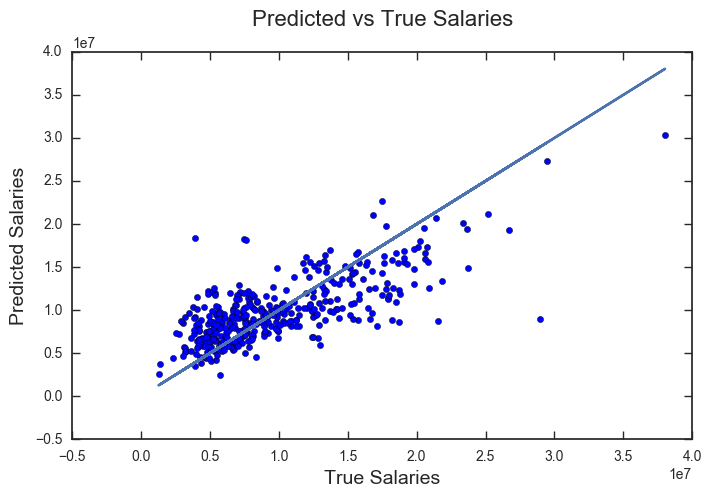

In [34]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.scatter(y_gb_holdout, y_pred_gb)
ax.plot(y_gb_holdout, y_gb_holdout)
ax.set_xlabel('True Salaries', fontsize='14')
ax.set_ylabel('Predicted Salaries',fontsize='14')
ax.set_title('Predicted vs True Salaries',fontsize='16')

sns.set_style("white")
sns.set_style('ticks')
sns.set_style({'xtick.direction': u'in', 'ytick.direction': u'in'})

ttl_gb = ax.title
ttl_gb.set_position([.5, 1.05])



## Plot the hyper parameters versus the test/training score

In [ ]:
plot_overfit(X_gb_holdout, y_gb_holdout, GradientBoostingRegressor, {'max_features':range(1,10)})

In [ ]:
plot_overfit(X_gb, y_gb, GradientBoostingRegressor, {'n_estimators':range(1,110,10)})

In [ ]:
plot_overfit(X_gb, y_gb, GradientBoostingRegressor, {'min_samples_split':range(5,50,5)})

In [ ]:
plot_overfit(X_gb, y_gb, linear_model.Lasso, {'alpha':[.01,.1,1,10,100,1000]})

## Plot PER vs Salary and highlight the outliers (if any)

In [14]:
worst = df_final[df_final['PER'] < -18]
worst

,Unnamed: 0,NAME,Yr,SALARY,salary_adj,Tm,Age,G,MP,PER,...,PTS,STL,TOV,TRB,eFG%,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG
921,921,Vin Baker,2005,14625000,18878014,HOU,33,3,13,-18.3,...,2,0,2,2,0.0,1.0,0.0,0.0,0.0,0.0


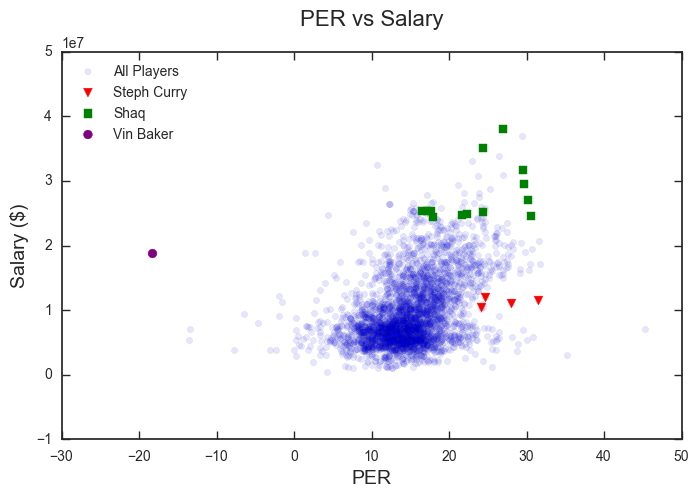

In [35]:
fig_PER, ax_PER = plt.subplots(1,1,figsize=(8,5))

PER_list = df_final['PER'].tolist()
salary_list = df_final['salary_adj'].tolist()

steph = df_final[df_final['NAME'] == 'Stephen Curry']
steph_PER = steph['PER'].tolist()
steph_sal = steph['salary_adj'].tolist()

shaq = df_final[df_final['NAME'] == "Shaquille O'Neal"]
shaq_PER = shaq['PER'].tolist()
shaq_sal = shaq['salary_adj'].tolist()

vin = df_final[df_final['PER'] < -18]
vin_PER = vin['PER'].tolist()
vin_sal = vin['salary_adj'].tolist()

ax_PER.scatter(PER_list, salary_list, label='All Players', alpha=.1)
ax_PER.scatter(steph_PER, steph_sal, color='red', label='Steph Curry', marker='v', s=40)
ax_PER.scatter(shaq_PER, shaq_sal, color='green', label='Shaq', marker='s', s=40)
ax_PER.scatter(vin_PER, vin_sal, color='purple', label='Vin Baker', marker='o', s=40)

ax_PER.set_title('PER vs Salary', fontsize='16')
ax_PER.set_xlabel('PER', fontsize='14')
ax_PER.set_ylabel('Salary ($)', fontsize='14')
ax_PER.legend(loc=2)

sns.set_style("white")
sns.set_style('ticks')
sns.set_style({'xtick.direction': u'in', 'ytick.direction': u'in'})
sns.set_style({'legend.frameon': True})

ttl_PER = ax_PER.title
ttl_PER.set_position([.5, 1.05])

In [16]:
# Average of 11 runs of the model with different holdout and train/test sets.
l_avg = [.526,.45,.515,.44,.525,.433,.479,.539,.471,.456,.504]
rf_avg = [.548,.468,.549,.503,.522,.454,.489,.573,.497,.52,.487]
gb_avg = [.86,.789,.841,.827,.864,.820,.767,.833,.823,.827,.827]

avgs = [l_avg, rf_avg, gb_avg]

for avg in avgs:
    print('AVG: ', np.mean(avg))
    print('STD: ', np.std(avg))
    print('\n')


AVG:  0.485272727273
STD:  0.0362869646244


AVG:  0.51
STD:  0.0347275107084


AVG:  0.825272727273
STD:  0.0265709715465


